In [1]:
import sys

import numpy
import torch
sys.path.append("..")
from mobile_encoder.setup_mobile_sam import setup_model
checkpoint = torch.load('../weights/mobile_sam.pt', map_location=torch.device('cpu'))
mobile_sam = setup_model()
mobile_sam.load_state_dict(checkpoint,strict=True)

LR SCALES: [0.08589934592000005, 0.10737418240000006, 0.13421772800000006, 0.1677721600000001, 0.20971520000000007, 0.2621440000000001, 0.3276800000000001, 0.4096000000000001, 0.5120000000000001, 0.6400000000000001, 0.8, 1.0]


<All keys matched successfully>

In [2]:
mobile_sam

Sam(
  (image_encoder): TinyViT(
    (patch_embed): PatchEmbed(
      (seq): Sequential(
        (0): Conv2d_BN(
          (c): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
          (bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (1): GELU(approximate='none')
        (2): Conv2d_BN(
          (c): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
          (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
      )
    )
    (layers): ModuleList(
      (0): ConvLayer(
        (blocks): ModuleList(
          (0-1): 2 x MBConv(
            (conv1): Conv2d_BN(
              (c): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
              (bn): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            )
            (act1): GELU(approximate='none')
            (conv2): Conv2d_BN(
 

In [36]:
from segment_anything.utils.onnx import SimpleSamOnnxModel

In [37]:
onnx_model = SimpleSamOnnxModel(model=mobile_sam)

In [8]:
#for n, m in onnx_model.named_modules():
#    if isinstance(m, torch.nn.GELU):
#        m.approximate = "tanh"

In [9]:
from PIL import Image

In [10]:
image = Image.open('../notebooks/images/picture1.jpg')
image.size

(769, 770)

In [11]:
image = image.resize((1024,1024))

In [12]:
import numpy as np
test_image = torch.Tensor(np.moveaxis(np.array(image).astype(np.float32), -1, 0))

In [13]:
dynamic_axes = {
        "point_coords": {1: "num_points"},
    }

embed_dim = mobile_sam.prompt_encoder.embed_dim
embed_size = mobile_sam.prompt_encoder.image_embedding_size
mask_input_size = [4 * x for x in embed_size]
dummy_inputs = {
    "x": test_image.unsqueeze(0),
    "point_coords": torch.Tensor([[[530.,265.], [530.,530]]]),#torch.randint(low=0, high=1024, size=(1, 1, 2), dtype=torch.float),
}

In [14]:
out = onnx_model(**dummy_inputs)

In [15]:
mask_input_size

[256, 256]

In [16]:
embed_dim

256

In [17]:
dummy_inputs["point_coords"].shape

torch.Size([1, 2, 2])

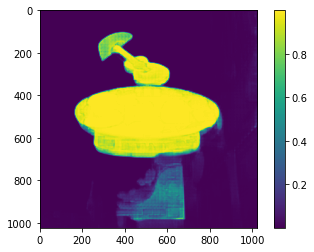

In [18]:
import matplotlib.pyplot as plt
plt.show()
plt.imshow(torch.squeeze(out[0]))
plt.colorbar()

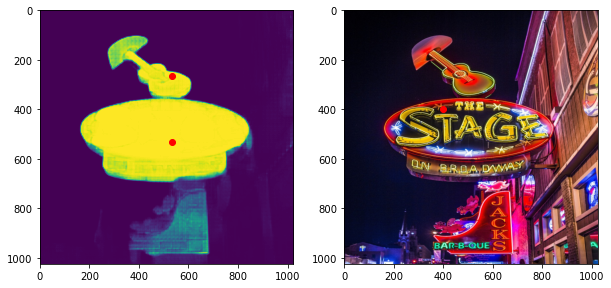

In [19]:
plt.figure(figsize=(10,20))
plt.subplot(1, 2, 1)
plt.imshow(torch.nn.functional.sigmoid(torch.squeeze(out[0])))
plt.plot([x*1024/770 for x in [400,400]], [x*1024/770 for x in [400,200]], 'ro')
plt.subplot(1, 2, 2)
plt.imshow(image)
plt.plot([400], [400], 'ro')
plt.show()

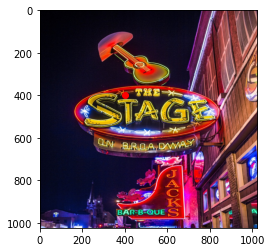

In [20]:
plt.imshow(image)
plt.plot([400], [400], 'ro')

In [21]:
(770/1024)*770

579.00390625

In [22]:
output_names = ["masks", "iou_predictions", "low_res_masks"]

In [23]:
import warnings
with warnings.catch_warnings():
    warnings.filterwarnings("ignore", category=torch.jit.TracerWarning)
    warnings.filterwarnings("ignore", category=UserWarning)
    output = "mobile_sam.onnx"
    with open("mobile_sam.onnx", "wb") as f:
        print(f"Exporting onnx model to {output}...")
        torch.onnx.export(
            onnx_model,
            tuple(dummy_inputs.values()),
            f,
            export_params=True,
            verbose=False,
            opset_version=17,
            do_constant_folding=True,
            input_names=list(dummy_inputs.keys()),
            output_names=output_names,
            dynamic_axes=dynamic_axes,
        )

Exporting onnx model to mobile_sam.onnx...
================ Diagnostic Run torch.onnx.export version 2.0.0 ================
verbose: False, log level: Level.ERROR
======================= 0 NONE 0 NOTE 0 WARNING 0 ERROR ========================



In [24]:
#assert onnxruntime_exists, "onnxruntime is required to quantize the model."
from onnxruntime.quantization import QuantType  # type: ignore
from onnxruntime.quantization.quantize import quantize_dynamic  # type: ignore

#print(f"Quantizing model and writing to {args.quantize_out}...")
quantize_dynamic(
    model_input="mobile_sam.onnx",
    model_output="mobile_sam_8bit.onnx",
    optimize_model=True,
    per_channel=False,
    reduce_range=False,
    weight_type=QuantType.QUInt8,
)

Ignore MatMul due to non constant B: /[/image_encoder/layers.1/blocks.0/attn/MatMul]
Ignore MatMul due to non constant B: /[/image_encoder/layers.1/blocks.0/attn/MatMul_1]
Ignore MatMul due to non constant B: /[/image_encoder/layers.1/blocks.1/attn/MatMul]
Ignore MatMul due to non constant B: /[/image_encoder/layers.1/blocks.1/attn/MatMul_1]
Ignore MatMul due to non constant B: /[/image_encoder/layers.2/blocks.0/attn/MatMul]
Ignore MatMul due to non constant B: /[/image_encoder/layers.2/blocks.0/attn/MatMul_1]
Ignore MatMul due to non constant B: /[/image_encoder/layers.2/blocks.1/attn/MatMul]
Ignore MatMul due to non constant B: /[/image_encoder/layers.2/blocks.1/attn/MatMul_1]
Ignore MatMul due to non constant B: /[/image_encoder/layers.2/blocks.2/attn/MatMul]
Ignore MatMul due to non constant B: /[/image_encoder/layers.2/blocks.2/attn/MatMul_1]
Ignore MatMul due to non constant B: /[/image_encoder/layers.2/blocks.3/attn/MatMul]
Ignore MatMul due to non constant B: /[/image_encoder/l

In [25]:
!ls -lh mobile_sam*.onnx

-rw-r--r--  1 ishani  staff    42M Jun 27 23:00 mobile_sam.onnx
-rw-r--r--  1 ishani  staff    23M Jun 27 23:00 mobile_sam_8bit.onnx


In [26]:
import onnxruntime

In [27]:
def to_numpy(tensor):
    return tensor.cpu().numpy()

In [28]:
ort_inputs = {k: to_numpy(v) for k, v in dummy_inputs.items()}
# set cpu provider default
providers = ["CPUExecutionProvider"]
ort_session = onnxruntime.InferenceSession(output, providers=providers)
out_onnx = ort_session.run(None, ort_inputs)

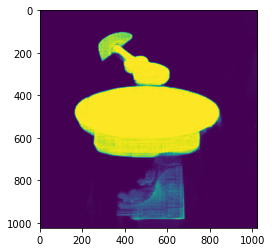

In [29]:
plt.figure()
plt.imshow(np.squeeze(out_onnx[0]))
plt.show()

In [30]:
!pip install coremltools

In [31]:
import coremltools as ct


In [32]:
with torch.no_grad():
    onnx_model.eval()
    model = onnx_model.cpu()
    model.requires_grad_(False)
    traced_model = torch.jit.trace(onnx_model, example_inputs=(dummy_inputs["x"], dummy_inputs["point_coords"]))

/Users/ishani/Documents/GitHub/MobileSAM/mobile_encoder/tiny_vit_sam.py:336: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  assert L == H * W, "input feature has wrong size"
/Users/ishani/Documents/GitHub/MobileSAM/mobile_encoder/tiny_vit_sam.py:136: TracerWarning: Using len to get tensor shape might cause the trace to be incorrect. Recommended usage would be tensor.shape[0]. Passing a tensor of different shape might lead to errors or silently give incorrect results.
  B = len(x)
/Users/ishani/Documents/GitHub/MobileSAM/segment_anything/utils/onnx.py:177: TracerWarning: torch.Tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time yo

In [33]:
traced_model

SimpleSamOnnxModel(
  original_name=SimpleSamOnnxModel
  (mask_decoder): MaskDecoder(
    original_name=MaskDecoder
    (transformer): TwoWayTransformer(
      original_name=TwoWayTransformer
      (layers): ModuleList(
        original_name=ModuleList
        (0): TwoWayAttentionBlock(
          original_name=TwoWayAttentionBlock
          (self_attn): Attention(
            original_name=Attention
            (q_proj): Linear(original_name=Linear)
            (k_proj): Linear(original_name=Linear)
            (v_proj): Linear(original_name=Linear)
            (out_proj): Linear(original_name=Linear)
          )
          (norm1): LayerNorm(original_name=LayerNorm)
          (cross_attn_token_to_image): Attention(
            original_name=Attention
            (q_proj): Linear(original_name=Linear)
            (k_proj): Linear(original_name=Linear)
            (v_proj): Linear(original_name=Linear)
            (out_proj): Linear(original_name=Linear)
          )
          (norm2): La

In [34]:
input_shape = ct.Shape(shape=(1,
                              ct.RangeDim(lower_bound=1, upper_bound=10, default=1),
                              2
                              ))

In [35]:
ct.convert(traced_model,
       inputs=[ct.ImageType("image", shape=[1,3,1024,1024], scale=1.0, bias=[0,0,0]),
              ct.TensorType(shape=input_shape, name="inputs")],
           outputs=[ct.ImageType(name="mask", color_layout=ct.colorlayout.GRAYSCALE)]
              )

Converting PyTorch Frontend ==> MIL Ops:  62%|██████▏   | 1246/1994 [00:00<00:00, 2271.74 ops/s]


RuntimeError: PyTorch convert function for op 'repeat_interleave' not implemented.

In [ ]:
import torchvision.transforms as T

In [ ]:
img_tensor = T.ToTensor()(image)

In [ ]:
x = mobile_sam.preprocess(img_tensor.unsqueeze(0))

In [ ]:
values = mobile_sam.image_encoder(x)

In [ ]:
values

In [ ]:
values.shape

In [ ]:
embed_dim

In [ ]:
embed_size

In [ ]:
mobile_sam.pixel_mean